In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
output_dir = os.path.join(os.path.curdir, 'output') 

In [4]:
from bayesfilt import KalmanFilter, UnscentedKalmanFilter, ExtendedKalmanFilter
from bayesfilt import ConstantVelocityND, ConstantAccelerationND, LinearObservationModel

## Observations

In [5]:
t = np.load(os.path.join(output_dir, 'tlist.npy'))
yobs = np.load(os.path.join(output_dir, 'yobs.npy'))
ytrue = np.load(os.path.join(output_dir, 'ytrue.npy'))

## Model

In [50]:
#CV
observed = {0:0, 1:2} # observation-state pairs
truth = {0:0, 6:1, 1:2, 5:3} # truth-state pairs

dt = 0.01
start_x = [yobs[0,0], 0.001, yobs[1,0], 0.001]
start_P = np.diag([0.5]*4)
mm = ConstantVelocityND(dof=2)
mm.update(dt = dt, sigmas = [0.5]*2)
om = LinearObservationModel(nx=mm.nx, observed=observed)
om.update(sigmas=[0.1]*2)

# CA
# observed = {0:0, 1:3} # observation-state pairs
# truth = {0:0, 6:1, 8:2, 1:3, 5:4, 7:5} # truth-state pairs of indices
# dt = 0.005
# start_x = [yobs[0,0], 0.001, 0, yobs[1,0], 0.001, 0.]
# start_P = np.diag([0.5]*6)
# mm = ConstantAccelerationND(dof=2)
# mm.update(dt = dt, sigmas = [1.0]*2)
# om = LinearObservationModel(nx=mm.nx, observed=observed)
# om.update(sigmas=[0.2]*2)

## Kalman Filter

In [51]:
kf = KalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
kf.F = mm.F.copy()
kf.H = om.H.copy()
kf.R = om.R.copy()

## Variation of performance metrics with varying model error strength

In [52]:
def run_kf(isigma):
    #print(isigma)
    kf.initiate_state(t[0], start_x, start_P)
    mm.update(dt = dt, sigmas = [isigma]*2)
    kf.Q = mm.Q.copy()
    kf.filter(t[1:], [ix for ix in yobs[:,1:].T], list_of_truth=[iy for iy in ytrue[list(truth.keys()), 1:].T])
    kf.smoother()
    return kf.metrics, kf.metrics_smoother

In [53]:
sigma_list = np.linspace(0.5, 4.0, 11)
#sigma_list = np.linspace(4.5, 8.5, 11)
metric_list = [run_kf(isigma) for isigma in sigma_list]

Text(0, 0.5, 'Log-likelihood, Smoother')

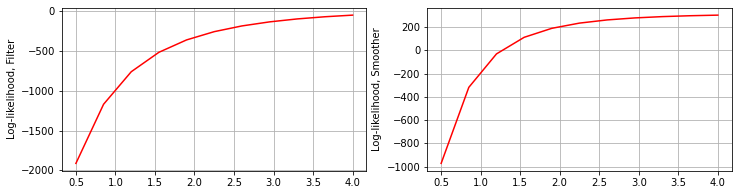

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
ax[0].plot(sigma_list, [fmetric['loglik'] for fmetric, smetric in metric_list], '-r')
ax[0].grid(True)
ax[0].set_ylabel('Log-likelihood, Filter')
ax[1].plot(sigma_list, [smetric['loglik'] for fmetric, smetric in metric_list], '-r')
ax[1].grid(True)
ax[1].set_ylabel('Log-likelihood, Smoother')

Text(0, 0.5, 'nis, Smoother')

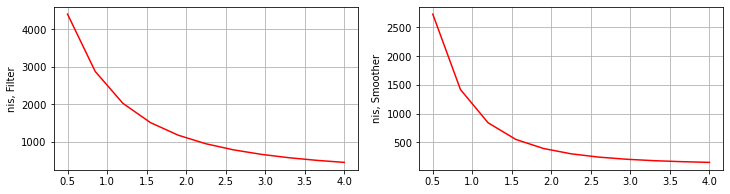

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
ax[0].plot(sigma_list, [fmetric['nis'] for fmetric, smetric in metric_list], '-r')
ax[0].grid(True)
ax[0].set_ylabel('nis, Filter')
ax[1].plot(sigma_list, [smetric['nis'] for fmetric, smetric in metric_list], '-r')
ax[1].grid(True)
ax[1].set_ylabel('nis, Smoother')

Text(0, 0.5, 'nees, Smoother')

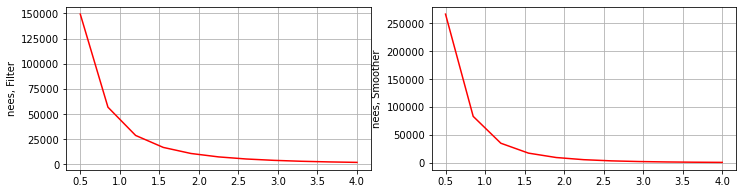

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))
ax[0].plot(sigma_list, [fmetric['nees'] for fmetric, smetric in metric_list], '-r')
ax[0].grid(True)
ax[0].set_ylabel('nees, Filter')
ax[1].plot(sigma_list, [smetric['nees'] for fmetric, smetric in metric_list], '-r')
ax[1].grid(True)
ax[1].set_ylabel('nees, Smoother')